### Machine Learning Audio Classification MFCC ResNet-32
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

Important Reads:
* https://arxiv.org/pdf/1807.09902.pdf (dataset paper)


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
import helper
import importlib
import h5py
#from netplot import ModelPlot # this fucking library uses a weird version of numpy so we are not gonna use it
from tensorflow.keras.utils import plot_model
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set the random seed
tf.random.set_seed(42)
np.random.seed(42)

# are we resuming training?
resume = False

2.7.0
Num GPUs Available:  1


### Core ResNet Structures
A ResNet can be called an upgraded version of the VGG architecture, with the difference between them being the skip connections used in ResNets. In the figure below, we can see the architecture of the VGG as well as the 34 layer ResNet.



In [3]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

### MFCC FEATURE READ IN
In this section we will read in our kaggle 2018 datasets which have already been featured extracted and normalized

In [4]:
# data set root
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)

# the cached feature extraction data root folder
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load in pre-processed MFCC train data
X_train = np.load( os.path.join(data_npy_folder, "X-mfcc-train.npy" ) )
y_train = np.load( os.path.join(data_npy_folder, "y-mfcc-train.npy" ) )

# load in pre-processed MFCC train data
X_test = np.load( os.path.join(data_npy_folder, "X-mfcc-test.npy" ) )
y_test = np.load( os.path.join(data_npy_folder, "y-mfcc-test.npy" ) )


In [5]:
# output X_train and X_test shape
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# output y_train and y_test shape
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (9473, 40, 345), X_test shape: (1600, 40, 345)
y_train shape: (9473,), y_test shape: (1600,)


### Visualize the label count distribution for train and test data

(array(['Hi-hat', 'Saxophone', 'Trumpet', ..., 'Laughter', 'Chime',
        'Cough'], dtype='<U21'),
 9473)

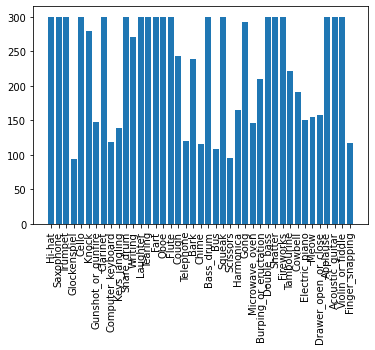

In [6]:
# visualize the label count distribution
labels = dict(zip(y_train,map(list(y_train).count, y_train)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

y_train, len(y_train)

<BarContainer object of 41 artists>

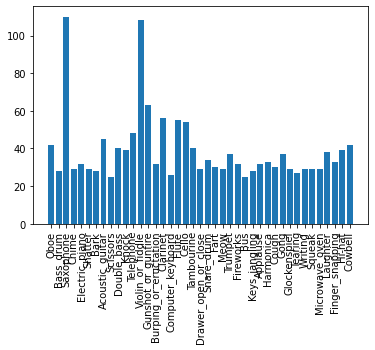

In [7]:
labels = dict(zip(y_test,map(list(y_test).count, y_test)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

### Encode Labels
In this section we will encode to categorical our y data

In [11]:
# encode the labels to categorical
le = LabelEncoder()

y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.fit_transform(y_test))


['Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Burping_or_eructation',
 'Bus',
 'Cello',
 'Chime',
 'Clarinet',
 'Computer_keyboard',
 'Cough',
 'Cowbell',
 'Double_bass',
 'Drawer_open_or_close',
 'Electric_piano',
 'Fart',
 'Finger_snapping',
 'Fireworks',
 'Flute',
 'Glockenspiel',
 'Gong',
 'Gunshot_or_gunfire',
 'Harmonica',
 'Hi-hat',
 'Keys_jangling',
 'Knock',
 'Laughter',
 'Meow',
 'Microwave_oven',
 'Oboe',
 'Saxophone',
 'Scissors',
 'Shatter',
 'Snare_drum',
 'Squeak',
 'Tambourine',
 'Tearing',
 'Telephone',
 'Trumpet',
 'Violin_or_fiddle',
 'Writing']

In [19]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

n_c = 0
#y_train[0], y_train_encoded[0], num_labels
y_train_encoded[n_c], le.classes_[n_c], num_labels

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'Acoustic_guitar',
 41)

### Reshape Data
In this section we will reshape our X data to be placed into the neural network

In [20]:
n_mfcc = 40
sampling_rate = 44100
audio_duration = 4 # we adjusted the input data from 2 seconds to 4
audio_length = audio_duration * sampling_rate
input_shape = (n_mfcc, 1 + int(np.floor(audio_length/512)), 1)
input_shape

(40, 345, 1)

In [21]:
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)

### Construct the model
In this section we will construct the model

In [22]:
if resume is False: # if we are not resuming from a previous model
    model = ResNet34(input_shape, num_labels) # create the model

2022-02-12 23:58:03.070030: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-12 23:58:03.071975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 23:58:03.072617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 23:58:03.073447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### compile and visualise the model
Yes, batch size affects Adam optimizer. Common batch sizes 16, 32, and 64 can be used. Results show that there is a sweet spot for batch size, where a model performs best. For example, on MNIST data, three different batch sizes gave different accuracy as shown in the table below:
```
|Batch Size | Test Accuracy        |
-----------------------------------|
|1024       |  96% with 30 epochs  |
|64         |  98% with 30 epochs  |
|2          |  99% with 30 epochs  |
|__________________________________|
```
https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer
<br>

### Categorical Crossentropy

**categorical_crossentropy:** Used as a loss function for multi-class classification model where there are two or more output labels. The output label is assigned one-hot category encoding value in form of 0s and 1. The output label, if present in integer form, is converted into categorical encoding using keras.

In [23]:
# 2. compile the model
if resume is False:
    learing_rate = 0.000001 # 5
    beta_1 = 0.99
    beta_2 = 0.999

    num_epochs = 500 # standard we are training for 500 epochs
    num_batch_size = 32 # NOTE: for resnets batch size seems to be the best hyper parameter that improves performance

    model.compile(
        loss = "categorical_crossentropy", # mean absolute error predicted vs observed
        # previous failure training used 1e-4, beta_1=0.99, beta_2=0.999, only achieved a val_loss did not improve from 0.04701
        optimizer = tf.keras.optimizers.Adam(learning_rate=learing_rate, beta_1=beta_1, beta_2=beta_2), # stochastic gradient descent (lr=1e-3)
        metrics=['accuracy'] # metrics accuracy
    )

### visualise the model

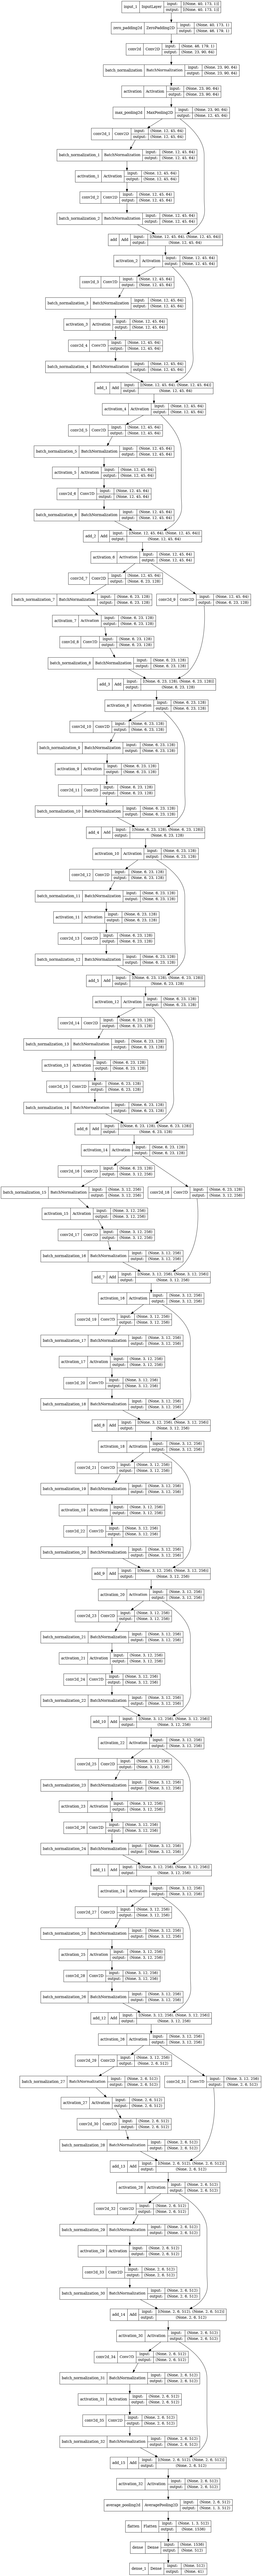

In [15]:

plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

### train the model

In [24]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')

if resume is False:
    # this is where we will save the model too
    model_path = os.path.join(model_dir, f'MFCC_RESNET32_lr-{learing_rate}_b1-{beta_1}_b2-{beta_2}_EPOCH-{num_epochs}_BATCH-{num_batch_size}_cc_v4.h5')
else:
    print("Model resuming not implemented yet")
    pass
    # num_epochs = 250
    # num_batch_size = 32 # recommend keeping same as saved model
    # print("Resuming training...")
    # model_path = os.path.join(model_dir, 'n/a')
    # # Load best saved model
    # print("Loading best saved model...")
    # model = load_model(model_path)

model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/MFCC_RESNET32_lr-1e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v4.h5'

In [25]:
# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

start = datetime.now()

# 3. train the model

history = model.fit(
    X_train, 
    y_train_encoded, 
    validation_data=(X_test, y_test_encoded),
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    #validation_split=1/12.,
    callbacks=[checkpointer, early_stopping_callback], 
    verbose=1
)

end = datetime.now() - start
print("Training time: {}".format(end))

Epoch 1/500


2022-02-12 23:59:32.127990: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


297/297 [==============================] - ETA: 0s - loss: 4.2318 - accuracy: 0.0519
Epoch 00001: val_loss improved from inf to 3.91794, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/MFCC_RESNET32_lr-1e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v4.h5


/home/charlesedwards/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


297/297 [==============================] - 36s 93ms/step - loss: 4.2318 - accuracy: 0.0519 - val_loss: 3.9179 - val_accuracy: 0.0156
Epoch 2/500
297/297 [==============================] - ETA: 0s - loss: 3.3613 - accuracy: 0.1494
Epoch 00002: val_loss improved from 3.91794 to 3.59856, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/MFCC_RESNET32_lr-1e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v4.h5
297/297 [==============================] - 26s 89ms/step - loss: 3.3613 - accuracy: 0.1494 - val_loss: 3.5986 - val_accuracy: 0.0650
Epoch 3/500
297/297 [==============================] - ETA: 0s - loss: 3.0826 - accuracy: 0.2108

Text(0.5, 0, 'epochs')

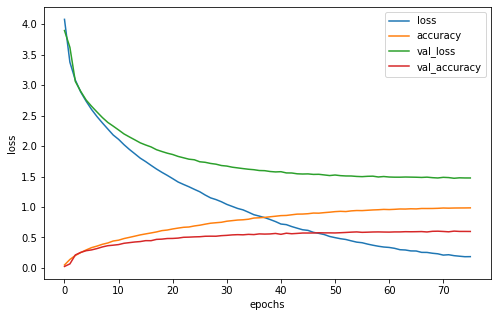

In [ ]:
# plot history also known as loss curve 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

In [ ]:

model.metrics_names

['loss', 'accuracy']

In [ ]:
# set the model path
model_path = os.path.join( dataset_root_dir, 'models')
#model_path = os.path.join(model_dir, "V3/RESNET")
model_path = os.path.join(model_path, f'MFCC_RESNET32_lr-1e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v4.h5')
model = load_model(model_path)

2022-02-12 17:37:10.191790: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-12 17:37:10.193191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 17:37:10.193477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 17:37:10.193719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
importlib.reload(helper)
helper.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

2022-02-12 17:37:16.358756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


50/50 [==============================] - 2s 25ms/step - loss: 1.4712 - accuracy: 0.6044
                    LOSS      ACCURACY
--------------------------------------
Training:         0.0669       99.8839
Test:             1.4712       60.4375
Normal diff         95.45 


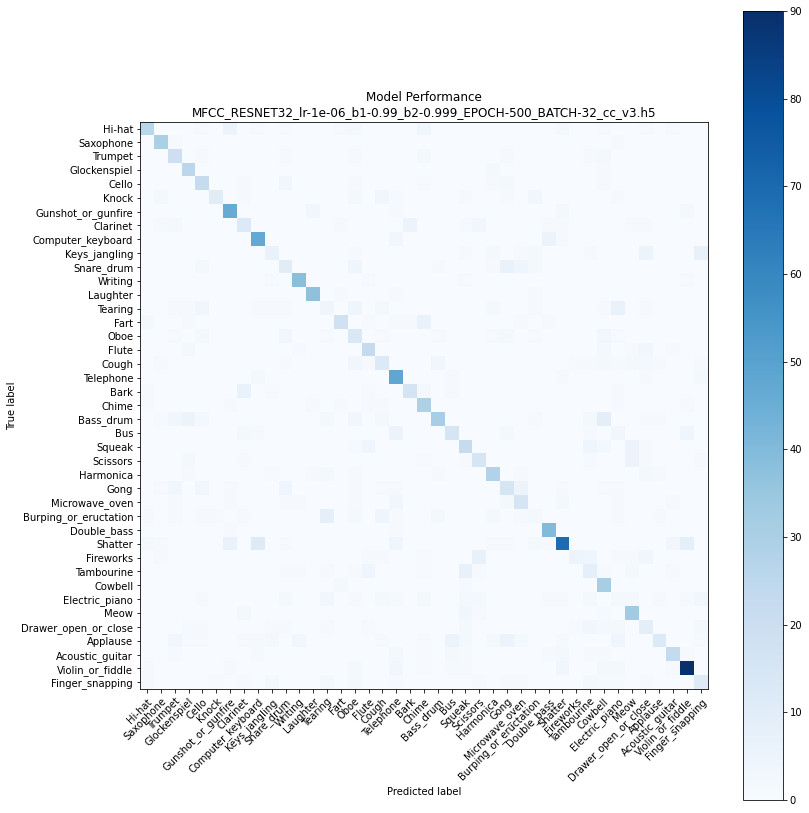

In [ ]:

importlib.reload(helper)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helper.plot_confusion_matrix(
    cm=cm,
    classes=le.classes_.tolist(),
    normalized=False, 
    title=f"Model Performance\n{model_path.split('/')[-1]}", 
    cmap=plt.cm.Blues,
    size=(12,12))

### Custom H5PY format
This section will append the label information into the h5 model so that our interface program can easily load these models

In [ ]:
model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/V3/RESNET/MFCC_RESNET32_lr-1e-06_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v3.h5'

In [ ]:
model, meta_data = helper.load_model_ext(model_path)
model, meta_data

2022-02-12 17:42:37.922513: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-12 17:42:37.923930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 17:42:37.924188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 17:42:37.924401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

(<keras.engine.functional.Functional at 0x7f13f28c02b0>,
 '["Hi-hat", "Saxophone", "Trumpet", "Glockenspiel", "Cello", "Knock", "Gunshot_or_gunfire", "Clarinet", "Computer_keyboard", "Keys_jangling", "Snare_drum", "Writing", "Laughter", "Tearing", "Fart", "Oboe", "Flute", "Cough", "Telephone", "Bark", "Chime", "Bass_drum", "Bus", "Squeak", "Scissors", "Harmonica", "Gong", "Microwave_oven", "Burping_or_eructation", "Double_bass", "Shatter", "Fireworks", "Tambourine", "Cowbell", "Electric_piano", "Meow", "Drawer_open_or_close", "Applause", "Acoustic_guitar", "Violin_or_fiddle", "Finger_snapping"]')

In [ ]:
import json
lables_properly = le.classes_.tolist() #train_metadata['label'].unique()
labels_json = json.dumps(list(lables_properly))
labels_json

'["Hi-hat", "Saxophone", "Trumpet", "Glockenspiel", "Cello", "Knock", "Gunshot_or_gunfire", "Clarinet", "Computer_keyboard", "Keys_jangling", "Snare_drum", "Writing", "Laughter", "Tearing", "Fart", "Oboe", "Flute", "Cough", "Telephone", "Bark", "Chime", "Bass_drum", "Bus", "Squeak", "Scissors", "Harmonica", "Gong", "Microwave_oven", "Burping_or_eructation", "Double_bass", "Shatter", "Fireworks", "Tambourine", "Cowbell", "Electric_piano", "Meow", "Drawer_open_or_close", "Applause", "Acoustic_guitar", "Violin_or_fiddle", "Finger_snapping"]'

In [ ]:
helper.save_model_ext(model, model_path, overwrite=True, meta_data=labels_json)

/home/charlesedwards/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
